<a href="https://colab.research.google.com/github/mgfrantz/CTME-llm-lecture-resources/blob/main/prototyping_ai/01_getting_started_with_openai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making our first LLM API call



## Setup

In [1]:
!pip install -Uqqqq \
    openai \
    chromadb \
    sentence-transformers \
    llama-index \
    llama-index-llms-openai \
    gradio \
    datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.7/268.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 11.4 

In [2]:
# Basic imports
from rich import print
import gradio as gr
import numpy as np
import os
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, cohen_kappa_score, mean_absolute_error

# OpenAI
from openai import OpenAI

## Setting our `OPENAI_API_KEY` environment variable

When we use any LLM provider like OpenAI, Anthropic, or Google, we need some way to tell them who we are making the request.
Today, we'll be using OpenAI.
The most straightforward way to provide this key is through the environment variable `OPENAI_API_KEY`.
The OpenAI python client looks for this environment variable to use in authentication.

In the cell below, we load it from the Google Colab secrets manager on the left 👈.
Before runnign this code, make sure your API key is set as shown below:

![](https://github.com/mgfrantz/CTME-llm-lecture-resources/blob/main/images/colabSecrets.png?raw=true)

In [55]:
# Set the OPENAI_API_KEY environment variable
from google.colab import userdata # import the environment variables from secrets
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY') # Set the OPENAI_API_KEY environmnet variable

## Under the hood: `curl`

Almost all of the interactions we will have with LLMs are through API calls.
Below is one of the most low-level ways we can call an LLM, using the `curl` command.
This command gives us a lot of information about how the API request is structured.
We pass a JSON with an authorization header containing our `OPENAI_API_KEY`.
We also pass the model we want to call, the chat messages, and hyperparameters such as `temperature` that help control how text is generated.

In [4]:
# Make the API call to OpenAI and store the response in test.json
!curl https://api.openai.com/v1/chat/completions \
  -H "Content-Type: application/json" \
  -H "Authorization: Bearer $OPENAI_API_KEY" \
  -d '{ \
     "model": "gpt-4o-mini", \
     "messages": [{"role": "user", "content": "Say: This is a test!"}], \
     "temperature": 0.7 \
    }' > test.json
# Show the output of test.json formatted nicely
!cat test.json | python -m json.tool

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   765  100   136   1075    191 --:--:-- --:--:-- --:--:--  1265
{
    "id": "chatcmpl-ATGWamKhTpWwyjviRAHlAMe5BEG53",
    "object": "chat.completion",
    "created": 1731538396,
    "model": "gpt-4o-mini-2024-07-18",
    "choices": [
        {
            "index": 0,
            "message": {
                "role": "assistant",
                "content": "This is a test!",
                "refusal": null
            },
            "logprobs": null,
            "finish_reason": "stop"
        }
    ],
    "usage": {
        "prompt_tokens": 14,
        "completion_tokens": 5,
        "total_tokens": 19,
        "prompt_tokens_details": {
            "cached_tokens": 0,
            "audio_tokens": 0
        },
        "completion_tokens_details": {
            "reasoning_tokens": 0,
            "audio_tokens": 0,
    

## Using the OpenAI Python client

While the `curl` command shows us how the API call is made, it's not something that we can easily use in more complex applications.
One thing we can use is the OpenAI python client.
We can do the exact same thing, but the API call is a bit more abstracted from the developer.
Let's see how to perform the exact same API call using the OpenAI clinet 👇:

In [5]:
client = OpenAI() # Create the OpenAI client

In [6]:
# Create the messages (same as above)
messages = [
    {"role": "user", "content": "Say: This is a test!"},
]

# Make the API call
chat_completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    # stream=True
)

In [7]:
# Display the output
print(chat_completion)

ChatCompletion(
    id='chatcmpl-ATGWbhqPvw7djQweqtF0ZCGUcyk43',
    choices=[
        Choice(
            finish_reason='stop',
            index=0,
            logprobs=None,
            message=ChatCompletionMessage(
                content='This is a test!',
                refusal=None,
                role='assistant',
                audio=None,
                function_call=None,
                tool_calls=None
            )
        )
    ],
    created=1731538397,
    model='gpt-4o-mini-2024-07-18',
    object='chat.completion',
    service_tier=None,
    system_fingerprint='fp_0ba0d124f1',
    usage=CompletionUsage(
        completion_tokens=5,
        prompt_tokens=14,
        total_tokens=19,
        completion_tokens_details=CompletionTokensDetails(
            accepted_prediction_tokens=0,
            audio_tokens=0,
            reasoning_tokens=0,
            rejected_prediction_tokens=0
        ),
        prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)
    )
)

# Build our first chatbots

In this section, we'll go through several demos.
By the end of this section, you should be able to:
- Build a basic chatbot with the popular `gradio` Python library
- Understand key hyperparameters like `temperature`, `top_p`, and `top_k`
- Build an advanced chatbot with hyperparameter controls

## Exercise: Building a basic chatbot with `gradio`

User interfaces (UIs) are a great way to demo work in AI.
In the next several lessons, we will be using the `gradio` framework to demonstrate our growing skillset.
In this exercise, we will get a gentle introduction to creating chatbots with `gradio`.

Please follow the [ChatInterface](https://www.gradio.app/docs/gradio/chatinterface) documentation and the [Creating a chatbot fast](https://www.gradio.app/guides/creating-a-chatbot-fast) guide to make your first AI chatbot.
Your chatbot must:
- respond to messages

If this too easy, try to:
- add a system prompt
- use `stream=True` in your chat function

In [8]:
def chat(message, history):
    if not history:
        history = [
            {"role": "system", "content": "You are a helpful assistant who speaks like a pirate."},
        ]
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=history,
        stream=True,
    )
    partial_message = ""
    for chunk in response:
        if chunk.choices[0].delta.content is not None:
              partial_message = partial_message + chunk.choices[0].delta.content
              yield partial_message

In [9]:
gr.ChatInterface(chat, type='messages').launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://353d6efd609129c214.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Text generation hyperparameters

There are several hyperparameters we can play with that determine how text is generated.
For each token, the model outputs a score distribution over words, and that distribution is normalized using the softmax function to sum to 1.0.
We have several options to modify this probability distribution in ways that affect the way text is generated.

### `temperature`

The softmax function is shown below:

$$
\text{softmax}(p) = \frac{e^{x_i}}{\sum_{j=0}^ne^{x_j}}
$$

The softmax function is defined in python below:


In [10]:
def softmax(p):
    return np.exp(p) / np.sum(np.exp(p))

# Example usage
p = np.array([1, 2, 3, 4, 5])
print(softmax(p))

[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]

The `temperature` paramater allows us to make the most probable words more probable (temperature < 1) or less probable (temperature > 1) than vanilla softmax (temperature = 1).
The formula for softmax with temperature is show below:

$$
\text{softmax}(p, T) = \frac{e^{\frac{x_i}{T}}}{\sum_{j=0}^ne^{\frac{x_j}{T}}}
$$

All you do is divide everything by T before taking the exponent; larger values of $T$ flatten the distribution, while smaller values of $T$ skew the distribution towards the most probable tokens.

### Demo: Softmax with temperature

In [11]:
# Softmax function with temperature parameter
def softmax_with_temperature(probs, temperature):
    exp_probs = np.exp(np.log(probs) / temperature)
    return exp_probs / np.sum(exp_probs)

In [12]:
# Define a small probability distribution
probs = np.array([0.5, 0.3, 0.1, 0.05, 0.05])

# Plot the distribution with numbers on top of each bar
def plot_distribution(temperature):
    adjusted_probs = softmax_with_temperature(probs, temperature)
    plt.figure(figsize=(6, 4))
    bars = plt.bar(range(len(probs)), adjusted_probs, tick_label=['A', 'B', 'C', 'D', 'E'])
    plt.ylim(0, 1)
    plt.title(f'Softmax with Temperature = {temperature:.2f}')
    plt.ylabel('Probability')
    plt.xlabel('Tokens')

    # Add numbers on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.show()

# Interactive widget
interact(plot_distribution, temperature=(0.1, 2.0, 0.1));

interactive(children=(FloatSlider(value=1.0, description='temperature', max=2.0, min=0.1), Output()), _dom_cla…

### Demo: Alter the `temperature` parameter

In this demo, we generate several messages from the same prompt.
If we lower the temperature to 0, what do you notice about the results?
What if we raise it above 1.0?

In [13]:
messages = [
    {"role": "user", "content": "Write a python function that reverses as tring. Tell a joke in the docstring!"},
]

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    temperature=1.0, # change this number between 0 and 2 to see the outcome
    n=3 # generate 3 choices
)

In [14]:
for choice in response.choices:
    print(choice.message.content)
    print('\n\n' + '='*50 + '\n')

Certainly! Below is a Python function that reverses a string, along with a light-hearted joke in the docstring.

```python
def reverse_string(s):
    """
    Reverses the given string.

    Why did the programmer quit his job?
    Because he didn't get arrays!

    Args:
        s (str): The string to be reversed.

    Returns:
        str: The reversed string.
    """
    return s[::-1]
```

You can use the `reverse_string` function by passing a string as an argument, and it will return the reversed 
version of that string!

==================================================

Here's a Python function that reverses a string, complete with a joke in the docstring:

```python
def reverse_string(s):
    """
    Reverses the input string.

    Why did the string break up with the number?
    Because it couldn't handle the integers!

    Parameters:
    s (str): The string to be reversed.

    Returns:
    str: The reversed string.
    """
    return s[::-1]

# Example usage
if __name__ == "__main__":
    example = "Hello, World!"
    reversed_example = reverse_string(example)
    print(reversed_example)  # Output: !dlroW ,olleH
```

You can use this function by passing any string to it, and it will return the reversed string. The joke is included
in the docstring for a bit of fun!

==================================================

Here's a Python function that reverses a string, complete with a joke in the docstring:

```python
def reverse_string(s):
    """
    Reverses the input string.

    Why do programmers prefer dark mode?
    Because light attracts bugs!

    Parameters:
    s (str): The string to be reversed.

    Returns:
    str: The reversed string.
    """
    return s[::-1]

# Example usage:
result = reverse_string("Hello, World!")
print(result)  # Output: !dlroW ,olleH
```

Feel free to use the `reverse_string` function and enjoy the joke!

==================================================

### Demo: `top_k`

In top k sampling, we define the number of tokens we want to consider to sample from.
For example if `top_k = 3`, we will take the scores of the top 3 tokens and apply the softmax to only those 3 scores.
Run the code block below to see how `top_k` normalizes the scores at different values.

In [15]:
# Define a small probability distribution
probs = np.array([0.5, 0.3, 0.1, 0.05, 0.05])

# Plot the distribution with numbers on top of each bar
def plot_top_k(top_k):
    ticks = ['A', 'B', 'C', 'D', 'E']
    sorted_probs = np.sort(probs)[::-1]
    top_k_probs = sorted_probs[:top_k]
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    adjusted_probs = softmax(probs)
    ax = axes[0]
    bars = ax.bar(range(len(probs)), adjusted_probs, tick_label=ticks)
    ax.set_ylim(0, 1)
    ax.set_title('Original Probabilities')
    ax.set_ylabel('Probability')
    ax.set_xlabel('Token')

    # Add numbers on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    ax = axes[1]
    if top_k < len(probs):
        updated_probs = softmax(probs[:top_k])
        bars = ax.bar(range(top_k), updated_probs, tick_label=ticks[:top_k])
    else:
        bars = ax.bar(range(len(probs)), softmax(probs), tick_label=ticks)
    ax.set_ylim(0, 1)
    ax.set_title(f'Top {top_k} Probabilities')
    ax.set_ylabel('Probability')
    ax.set_xlabel('Token')
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.show()

# Interactive widget
interact(plot_top_k, top_k=(1, len(probs), 1));

interactive(children=(IntSlider(value=3, description='top_k', max=5, min=1), Output()), _dom_classes=('widget-…

### Demo: `top_p` (aka nucleus sampling)

`top_p` is similar to `top_k`, but instead of defining the number of tokens to consider, you define a cutoff for cumulative probability.
For example, if you have a top_p of 0.6 and score of ('cat', 0.4), ('dog', 0.15), ('llama', 0.1), and ('parakeet', 0.01), you would cut only consider 'cat', 'dog', and 'llama' because 0.4 + 0.15 is less than 0.6, but 0.4 + 0.15 + 0.1 is greater.
Because you have a probability cutoff instead of number of tokens, this may mean you have different numbers of tokens considered at each decoding step.

Play around with the `top_p` slider below 👇 to get some intuition for how it works.

In [16]:
# Define a small probability distribution (can simulate a language model's logits)
probs = np.array([0.4, 0.2, 0.15, 0.1, 0.08, 0.05, 0.02])

# Function to apply top-p filtering with a minimum of one token selected
def top_p_filter(probs, p):
    sorted_probs = np.sort(probs)[::-1]
    cumulative_probs = np.cumsum(sorted_probs)

    # Ensure at least one token is selected
    if p < sorted_probs[0]:
        cutoff = 1
    else:
        cutoff = np.argmax(cumulative_probs >= p) + 1

    filtered_probs = sorted_probs[:cutoff]
    return filtered_probs, cutoff

# Plot the distribution with top-p filtering
def plot_top_p(p):
    filtered_probs, cutoff = top_p_filter(probs, p)
    normalized_probs = filtered_probs / np.sum(filtered_probs)  # Normalize the selected probabilities

    # Create two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

    # Plot 1: Original distribution with top-p filtering
    bars1 = axs[0].bar(range(len(probs)), np.sort(probs)[::-1], tick_label=labels)
    axs[0].set_ylim(0, 1)
    axs[0].set_title(f'Top-p Sampling (p = {p:.2f}) - Original Probabilities')
    axs[0].set_ylabel('Probability')
    axs[0].set_xlabel('Tokens')

    # Highlight selected and unselected probabilities
    for i, bar in enumerate(bars1):
        if i >= cutoff:
            bar.set_color('gray')  # Color the bars outside top-p as gray
        else:
            bar.set_color('blue')  # Highlight the selected probabilities

    # Add numbers on top of each bar for original distribution
    for bar in bars1:
        yval = bar.get_height()
        axs[0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    # Plot 2: Normalized probabilities of the selected tokens
    bars2 = axs[1].bar(range(len(filtered_probs)), normalized_probs, tick_label=labels[:len(filtered_probs)])
    axs[1].set_ylim(0, 1)
    axs[1].set_title(f'Normalized Probabilities of Selected Tokens (p = {p:.2f})')
    axs[1].set_ylabel('Normalized Probability')
    axs[1].set_xlabel('Selected Tokens')

    # Add numbers on top of each bar for normalized probabilities
    for bar in bars2:
        yval = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Interactive widget
interact(plot_top_p, p=(0.01, 1.0, 0.05));

interactive(children=(FloatSlider(value=0.46, description='p', max=1.0, min=0.01, step=0.05), Output()), _dom_…

## Exercise: Advanced chatbot with hyperparameter controls

Now that you've learned about roles and generation hyperparameters, let's create a new chatbot that allows you to contol at them.
Your chatbot must:
- allow for control of at least 1 generation hyperparameter (ex: `temperature`)
- allow for user input of a system message

If this is too easy, try to:
- allow for control over `temperature` and `top_p`
- improve the UI by putting all the controls in a sidebar
- have a `Clear` button that restarts the conversation
- add documentation with markdown
- implement streaming responses

In [17]:
def user(message:str, history:list, system_message:str):
    if not history and system_message:
        history.append(
            {"role": "system", "content": system_message},
        )
    # Append the user's message to the conversation history
    history.append({"role": "user", "content": message})
    return "", history

def bot(history, temperature, top_p):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=history,
        temperature=temperature,
        top_p=top_p,
        stream=True,
    )
    history.append({"role": "assistant", "content": ""})
    for chunk in response:
        if chunk.choices[0].delta.content is not None:
              history[-1]['content'] += chunk.choices[0].delta.content
              yield history

def clear():
    return "", []

In [18]:
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column(scale=1):
            temperature = gr.Slider(minimum=0, maximum=1, value=0.7, label="Temperature")
            top_p = gr.Slider(minimum=0, maximum=1, value=1, label="Top p")
            system_message = gr.Textbox(label="System message", value="You are a helpful assistant who speaks like a pirate.")
            clear_button = gr.Button("Clear messages")
        with gr.Column(scale=3):
            chatbot = gr.Chatbot(type='messages')
            input = gr.Textbox(label="Message", value="")
            input.submit(user, [input, chatbot, system_message], [input, chatbot]).then(
                bot, [chatbot, temperature, top_p], chatbot
            )
            clear_button.click(clear, [], [input, chatbot])

demo.launch()



Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4458452d692044cba4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Prompt engineering 1: zero-shot prompting

To really benchmark how each of these techniques do, we need a baseline.
We will use zero-shot prompting to get a base level of performance on our task.

So far, we've been using the low-level `openai` library.
However, there are several very competent higher-level libraries that provide great abstractions such as `langchain` and `llama-index`.
Today, we'll be using `llama-index` to make our LLM calls a bit easier.

## Prepare our dataset

In [19]:
# Prompt engineering imports
from datasets import load_dataset, Dataset
from llama_index.core import PromptTemplate
from llama_index.core.prompts import ChatMessage
from llama_index.llms.openai import OpenAI
from pydantic import BaseModel, Field
from IPython.display import display
import asyncio

In [20]:
ds = load_dataset('SetFit/amazon_reviews_multi_en')

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

validation.jsonl:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [21]:
train_samples_per_class = 50
eval_test_samples_per_class = 10
train = Dataset.from_pandas(ds['train'].to_pandas().groupby('label').sample(train_samples_per_class, random_state=1234).reset_index(drop=True))
valid = Dataset.from_pandas(ds['validation'].to_pandas().groupby('label').sample(eval_test_samples_per_class, random_state=1234).reset_index(drop=True))
test = Dataset.from_pandas(ds['test'].to_pandas().groupby('label').sample(eval_test_samples_per_class, random_state=1234).reset_index(drop=True))

In [22]:
train.to_pandas().sample(3)

,id,text,label,label_text
88,en_0317615,REF: Yankee Candle Autumn Wreath; The 2nd orde...,1,1
221,en_0396273,Great purchase! It’s my I watch perfect and ea...,4,4
172,en_0586174,"The relief is temporary, it's like anesthesia.",3,3


In [23]:
async def predict_and_evaluate(predict_fn):
    labels = [int(x) for x in valid['label']]
    tasks = [
        predict_fn(text)
        for text in valid['text']
    ]
    predictions = await asyncio.gather(*tasks)
    cm = ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='true')
    cr = classification_report(labels, predictions)
    kappa = cohen_kappa_score(labels, predictions, weights='quadratic')
    mae = mean_absolute_error(labels, predictions)
    return labels, predictions, kappa, mae, cm, cr

## Zero-shot prompt

In [24]:
prompt_tmpl_str = """\
The review text is below.
---------------------
{review}
---------------------
Given the review text and not prior knowledge, \
please attempt to predict the review score of the context.

Query: What is the rating of this review?
Answer: \
"""

prompt_tmpl = PromptTemplate(
    prompt_tmpl_str,
)

In [25]:
class Rating(BaseModel):
    rating: int = Field(..., description="Rating of the review", enum=[0, 1, 2, 3, 4])

llm = OpenAI(model="gpt-4o-mini")
zero_shot_structured_llm = llm.as_structured_llm(Rating)

In [26]:
async def zero_shot_predict(text):
    messages = [
        ChatMessage.from_str(prompt_tmpl.format(review=text))
    ]
    response = await zero_shot_structured_llm.achat(messages)
    return response.raw.rating

Cohen's Kappa: 0.8586, MAE: 0.48

precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.36      0.50      0.42        10
           2       0.42      0.50      0.45        10
           3       0.75      0.30      0.43        10
           4       0.71      1.00      0.83        10

    accuracy                           0.56        50
   macro avg       0.61      0.56      0.55        50
weighted avg       0.61      0.56      0.55        50

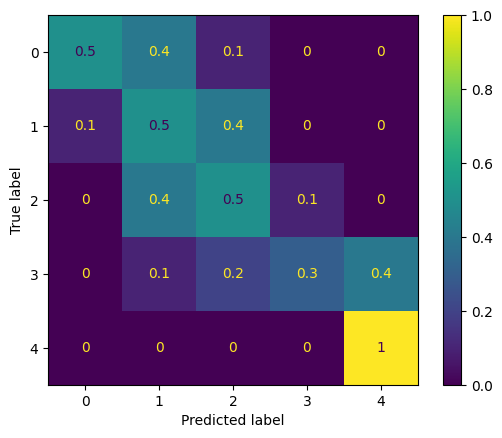

In [27]:
zero_shot_labels, zero_shot_predictions, zero_shot_kappa, zero_shot_mae, zero_shot_cm, zero_shot_cr = await predict_and_evaluate(zero_shot_predict)
print(f"Cohen's Kappa: {zero_shot_kappa:.04f}, MAE: {zero_shot_mae}")
print(zero_shot_cr)

# Prompt engineering 2: few-shot promting

In the following cell, we load and parse the data.
The data here is uber reviews

In [28]:
train.shuffle()[:5]

{'id': ['en_0948066', 'en_0798140', 'en_0574148', 'en_0861946', 'en_0035709'],
 'text': ['Arrived broken! Very dissatisfied.',
  "I'm only giving this book 3 stars because it is in dire need of an editor!!! There were many misspelled words and a lot of sentence structures that had the wrong word or the word placed in the wrong spot in the sentence. I got tired of rereading the sentences with me putting in the correct word or taking the word out altogether!! I did love Leonardo and Mallory's story and I would have given this book a much higher rating if it wasn't for the poor editing job!! It was very distracting and it took away from the story!",
  "They look great; I'd reccomend them and would purchase more",
  'A pain to assemble but bery nice once done.',
  'This is a truly inspiring Wicca Herbal Magic book. is a very helpful look at the Ultimate Encyclopedia on Wiccan Herbal . This book is recommended for highly effective! it was evidenced in the results I experienced.'],
 'label':

In [29]:
def random_few_shot_examples_fn(**kwargs):
    random_examples = train.shuffle()[:5]
    result_strs = []
    for text, rating in zip(random_examples['text'], random_examples['label']):
        result_strs.append(f"Text: {text}\nRating: {rating}")
    return "\n\n".join(result_strs)

In [30]:
print(random_few_shot_examples_fn())

Text: We found plain old cornstarch to be as effective, and without any sting.
Rating: 2

Text: I only use one time for my dog, it really work well, I can see the reduce the ear affection, but it has the 
small my dog doesn't like. If it can be no sense that would be better.
Rating: 3

Text: We have a small area and limited outlet availability. With the amount of electronics we have is hard to make 
room for all of it! This is super helpful to save on space! Fast charging and compatible with Apple (some products 
give you an error code; "not compatible" or whatever). Has been a life saver! Will probably order another one for 
our cars!
Rating: 4

Text: The book was in good condition and very informative.Thank you.
Rating: 3

Text: Amazon nape and eclectus birds didn’t care for it at all. Very small pieces.
Rating: 1

In [31]:
few_shot_prompt_tmpl_str = """\
The review text is below.
---------------------
{review}
---------------------
Given the review text and not prior knowledge, \
please attempt to predict the review score of the context. \
Here are several examples of reviews and their ratings:

{random_few_shot_examples}

Query: What is the rating of this review?
Answer: \
"""

few_shot_prompt_tmpl = PromptTemplate(
    few_shot_prompt_tmpl_str,
    function_mappings={"random_few_shot_examples": random_few_shot_examples_fn},
)

In [32]:
print(few_shot_prompt_tmpl.format(review='I loved this product!'))

The review text is below.
---------------------
I loved this product!
---------------------
Given the review text and not prior knowledge, please attempt to predict the review score of the context. Here are 
several examples of reviews and their ratings:

Text: Easy to understand and use.
Rating: 3

Text: Cut off leg circulation like no other. Went back to the Nike dri-fit cushions.
Rating: 1

Text: I did not overload these rollers, but they tilted easily and no way to repair if one of the caster breaks its
welding.
Rating: 1

Text: I really like this blanket. It has made a big difference in the time to get back to sleep after awaking in 
the night. It is not too hot either - I find it very comfortable.
Rating: 4

Text: When not in use there's no spillage but when I squeeze it, the cap comes off and all my sauce gets 
everywhere...
Rating: 2

Query: What is the rating of this review?
Answer:

In [33]:
class Rating(BaseModel):
    rating: int = Field(..., description="Rating of the review", enum=[0, 1, 2, 3, 4])

llm = OpenAI(model="gpt-4o-mini")
rand_few_shot_structured_llm = llm.as_structured_llm(Rating)

In [34]:
async def random_few_shot_predict(text):
    messages = [
        ChatMessage.from_str(few_shot_prompt_tmpl.format(review=text))
    ]
    response = await rand_few_shot_structured_llm.achat(messages)
    return response.raw.rating

Cohen's Kappa: 0.8824, MAE: 0.44

precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.38      0.50      0.43        10
           2       0.42      0.50      0.45        10
           3       0.67      0.20      0.31        10
           4       0.71      1.00      0.83        10

    accuracy                           0.58        50
   macro avg       0.61      0.58      0.56        50
weighted avg       0.61      0.58      0.56        50

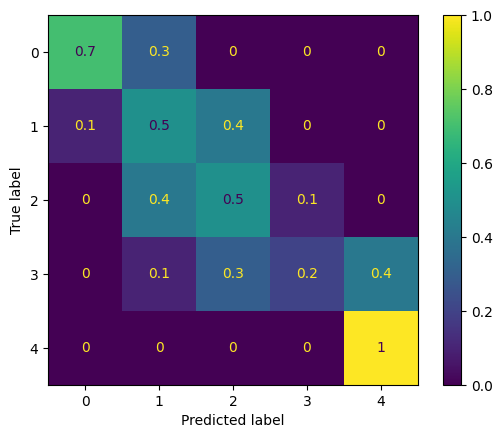

In [35]:
random_few_shot_labels, random_few_shot_predictions, random_few_shot_kappa, random_few_shot_mae, random_few_shot_cm, random_few_shot_cr = await predict_and_evaluate(random_few_shot_predict)
print(f"Cohen's Kappa: {random_few_shot_kappa:.04f}, MAE: {random_few_shot_mae}")
print(random_few_shot_cr)

# Demo: Embeddings and vector stores

In the previous demonstration, we saw that providing several randomly-selected examples to the LLM at inference time does decently well - it's decently good at predicting the review score, especially within 1 point of the actual review.
In a little bit, we'll see that providing better examples to the model at inference time helps improve these scores.
But we need efficient ways of searching over our `train` examples to determine which one to use.

This is when you want to use a vector store.
Vector stores can be in-memory stors, on-disk stores, database extensions like pgvector for Postgres, or even external APIs like Pinecone.

Today, we'll use a popular open-source vectore database called `chromadb`.
This tool allows us to ingest our documents and search over them effectively to determine which examples to use.

In this demo, we'll go over the basics of how to use ChromaDB.
We will also use `sentence-transformers` for embeddings as an example of how to use open-weights embedding models.

In [36]:
# Imports
from chromadb import Client
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In this cell, we declare our embedding function.
We will use the small but powerful [BGE-small](https://huggingface.co/BAAI/bge-small-en-v1.5) model to embed our documents.

In [37]:
embed_fn = SentenceTransformerEmbeddingFunction('BAAI/bge-small-en-v1.5')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Next, we can create our `chromadb` client and use it to create our collection (think table).
Notice that we pass our embedding function.
That way, when we add documents to the table, the the text is automatically embedded.

In [38]:
chroma_client = Client()

In [39]:
reviews = chroma_client.create_collection(
    name='reviews',
    embedding_function=embed_fn,
    get_or_create=True
)

In [40]:
reviews.add(documents=train['text'], metadatas=[{'rating': x} for x in train['label']], ids=train['id'])

Once we have created our vector store, we can search over it using plain text.
Here are 3 queries - good review, a neutral review, and a bad review.
Let's search our train documents and observe the average rating for the closest 5 documents to each fake review.

In [41]:
queries = [
    "This product is great!",
    "This product was pretty typical - not good or bad.",
    "This product was awful",
]

In [42]:
retrievals = reviews.query(
    query_texts=queries,
    n_results=5
)

In [43]:
for query, metadatas in zip(queries, retrievals['metadatas']):
    ratings = [float(i.get('rating')) for i in metadatas]
    print(f"Review {query}")
    print(f"Avg rating of retrieved passages: {np.mean(ratings)}")

Review This product is great!

Avg rating of retrieved passages: 3.8

Review This product was pretty typical - not good or bad.

Avg rating of retrieved passages: 1.4

Review This product was awful

Avg rating of retrieved passages: 0.6

In [44]:
reviews.query(query_texts = 'hello!')['documents']

[['Great purchase! It’s my I watch perfect and easy to attach!',
  'Great starter, works like it supposed to! Love it!',
  'Arrived on time. Buttons are well placed do not have to use excessive pressure.',
  "Very good, sit up soft, the key is won't heat, or clean, wipe clean. The store's service is also in place. The delivery is really fast.",
  'Just received, easy to set up and use.',
  'Love how structured it is for a small pillow! It’s nice to have the support and not take up the whole bed!',
  'Good product works great!',
  'A bit large for a size 8. But it shines so nice!! Looks great. It’s a tad brighter and lighter than my real diamonds but perhaps with wear it’ll settle in. Looks great with my real diamonds! Love it.',
  'My speaker is really loud and I’m happy about it... The instructions were simple and easy to follow but ... I didn’t receive any cords to charge the speaker or connect it to anything ... and still waiting for a response from the supplier or Amazon',
  "Got t

## Discussion: Using vector stores

Now that we have our data encoded this way, can anyone tell me how we might use this object to improve the way we classify reviews?

# Prompt engineering 3: dynamic few-shot prompting

In [45]:
def dynamic_few_shot_examples_fn(**kwargs):
    n_examples = kwargs.get('n_examples', 5)
    retrievals = reviews.query(
        query_texts=[kwargs['review']],
        n_results=n_examples
    )
    result_strs = []
    documents = retrievals['documents'][0]
    metadatas = retrievals['metadatas'][0]
    for document, metadata in zip(documents, metadatas):
        result_strs.append(f"Text: {document}\nRating: {metadata.get('rating')}")
    return "\n\n".join(result_strs)

In [46]:
print(dynamic_few_shot_examples_fn(review="This is the best uber ride of my life!"))

Text: Four wheels is easy to move, there is storage on both sides and cloth liner with a zipper so that small items
can be placed securely out of view under this lining. I'm traveling soon and will update after a period of time but
so far, I'm very pleased. TSA locks. That's good because, for some reason, every time I've traveled lately, my 
luggage has been inspected. Now, if they only provided someone to pack for me?
Rating: 4

Text: Received mines today.This drone is really fun to fly because of the speed and agility that it has.Great 
drone! It flies easy and is fast!Great little drone!!!Buy one of these and have fun!
Rating: 4

Text: Great purchase! It’s my I watch perfect and easy to attach!
Rating: 4

Text: Yes, it is a bit pricey. Not thrilled about that. I actually thought this was the brand I own, but it is not.
It fit well enough though. Had to make adjustments on the ottoman to accommodate though. Thank goodness for a handy
husband. Overall, I love the new life it gives the chair as well as the overall room. Cheerful pattern and comfy 
too. Delivered quickly and without damaged box.
Rating: 3

Text: Wore it on a onesie bar crawl - so comfy and loved the zipper. Made it much easier to get in and out of.
Rating: 4

In [47]:
print(dynamic_few_shot_examples_fn(review="This is the worst uber ride of my life!", n_examples=2))

Text: I would give this zero stars if I could. This product is a piece of crap! I used both protectors and on first
try, neither protectors stuck to the phone. It’s not like I tried multiple times for it to line up.. no it wouldn’t
stick on first try n i know how to put on screen protectors. Terrible product!
Rating: 0

Text: The delivery service is unacceptable, they drop the package over the gate ignoring the big barrel that has 
PACKAGES on a big sign, the dogs ruin the package, again. How stupid are these people?
Rating: 1

In [48]:
dynamic_few_shot_prompt_tmpl_str = """\
The review text is below.
---------------------
{review}
---------------------
Given the review text and not prior knowledge, \
please attempt to predict the review score of the context. \
Here are several examples of reviews and their ratings:

{dynamic_few_shot_examples}

Query: What is the rating of this review?
Answer: \
"""

dynamic_few_shot_prompt_tmpl = PromptTemplate(
    dynamic_few_shot_prompt_tmpl_str,
    function_mappings={"dynamic_few_shot_examples": dynamic_few_shot_examples_fn},
)

In [49]:
print(dynamic_few_shot_prompt_tmpl.format(review='I loved this product!', n_examples=1))

The review text is below.
---------------------
I loved this product!
---------------------
Given the review text and not prior knowledge, please attempt to predict the review score of the context. Here are 
several examples of reviews and their ratings:

Text: Good product works great!
Rating: 3

Query: What is the rating of this review?
Answer:

In [50]:
class Rating(BaseModel):
    rating: int = Field(..., description="Rating of the review", enum=[0, 1, 2, 3, 4])

llm = OpenAI(model="gpt-4o-mini")
dynamic_few_shot_structured_llm = llm.as_structured_llm(Rating)

async def dynamic_few_shot_predict(text):
    messages = [
        ChatMessage.from_str(dynamic_few_shot_prompt_tmpl.format(review=text))
    ]
    response = await dynamic_few_shot_structured_llm.achat(messages)
    return response.raw.rating

Cohen's Kappa: 0.8615, MAE: 0.42

precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.50      0.50      0.50        10
           2       0.47      0.70      0.56        10
           3       0.80      0.40      0.53        10
           4       0.77      1.00      0.87        10

    accuracy                           0.64        50
   macro avg       0.68      0.64      0.63        50
weighted avg       0.68      0.64      0.63        50

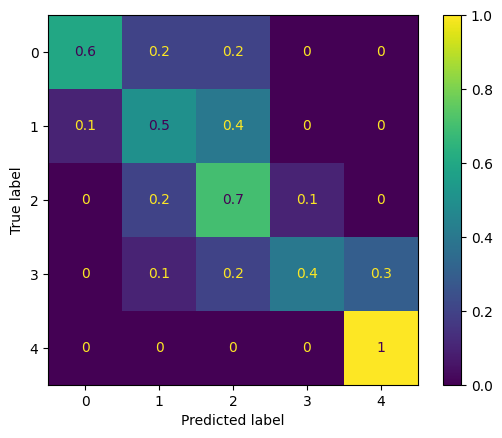

In [51]:
dynamic_few_shot_labels, dynamic_few_shot_predictions, dynamic_few_shot_kappa, dynamic_few_shot_mae, dynamic_few_shot_cm, dynamic_few_shot_cr = await predict_and_evaluate(dynamic_few_shot_predict)
print(f"Cohen's Kappa: {dynamic_few_shot_kappa:.04f}, MAE: {dynamic_few_shot_mae}")
print(dynamic_few_shot_cr)

# Exercise: Rating Reviews

In today's session, we've learned about:
- Chat models, interfaces, and `gradio`
- Zero shot prompting
- Few shot learning
- Embeddings and vector stores
- Dynamic few shot learning

It's time to combine these principles into our final exercise of the day.
Your task is to create a `gradio` app where a user can paste a review from Amazon and the app displays the predicted number of ⭐stars⭐.
To complete this task, please:
- Create a GradIO app with...
  - an input field where a user can submit text
  - a submit button and/or functionality to submit the text to the app when the user hits the return key
  - an output field to display the predicted result

If this is too easy, try to:
- Add hyperparameters like the number of examples retrieved
- Add details in markdown for how to use the app
- Display the prompt and response for inspection

If you're done, and **really** want to challenge yourslef, add a dropdown for a different model.
You can follow the `Gemini API keys` button in the 👈secrets🔑 tab of Colab, or follow [this notebook guide](https://github.com/mgfrantz/CTME-llm-lecture-resources/blob/main/resources/ollama.ipynb) on a GPU colab to try doing inference with local LLMs like llama3 (Recommended to restart and use a gpu runtime, runtime > change runtime type. May not work with `.as_structured_llm`, check out [this low-level guide on structured outputs](https://docs.llamaindex.ai/en/stable/examples/output_parsing/llm_program/)).


In [52]:
%%capture
!curl -fsSL https://ollama.com/install.sh | sh
!pip install -qqqq llama-index-llms-ollama ollama

In [67]:
!ollama serve > ollama.log 2>&1 &

In [ ]:
%%capture
!ollama pull llama3.2:3b

In [78]:
from llama_index.llms.ollama import Ollama
from llama_index.core.program import LLMTextCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser
from tenacity import retry, wait_fixed, stop_after_attempt

async def openai_predict(text, n_examples):
    OpenAI(model="gpt-4o-mini").as_structured_llm(Rating)
    messages = [
        ChatMessage.from_str(dynamic_few_shot_prompt_tmpl.format(review=text, n_examples=n_examples))
    ]
    response = await models[model].achat(messages)
    return response.raw.rating, messages[0].content, str(response)

@retry(wait=wait_fixed(2), stop=stop_after_attempt(3))
def ollama_predict(text, n_examples):
    llm = Ollama(model="llama3.2:3b")
    output_parser = PydanticOutputParser(Rating)
    prompt = dynamic_few_shot_prompt_tmpl.format(review=text, n_examples=n_examples)
    program = LLMTextCompletionProgram(llm=llm, output_parser=output_parser, output_cls=Rating, prompt=dynamic_few_shot_prompt_tmpl)
    response = program(review=text, n_examples=n_examples)
    return response.rating, prompt, str(response)


def _predict(text, model, n_examples):
    if model == 'OpenAI':
        return asyncio.run(openai_predict(text, n_examples))
    elif model == 'Ollama':
        return ollama_predict(text, n_examples)

In [79]:
with gr.Blocks() as demo:

    gr.Markdown("""\
# Amazon Rating Classifier

Ever wondered if your review matches the rating?
Copy and paste any Amazon review into the **Review** box and hit return to see the predicted rating.
""")
    with gr.Row():
        with gr.Column(scale=1):
            model_dropdown = gr.Dropdown(
                label="Model",
                choices=list(models.keys()),
                value=list(models.keys())[0],
            )
            n_examples = gr.Slider(minimum=1, maximum=10, step=1, value=5, label="Number of examples")
        with gr.Column(scale=5):
            input = gr.Textbox(label="Review")
            output = gr.Textbox(label="Rating")

    with gr.Row():
        message_display = gr.Textbox(label="Prompt")
        response_display = gr.Textbox(label="Response")

    input.submit(_predict, [input, model_dropdown, n_examples], [output, message_display, response_display])

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5d9f36b45b92bb16c1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7864 <> https://5d9f36b45b92bb16c1.gradio.live
